In [2]:
import mylib.feature_proc as myproc
import mylib.action_classifier as myclf
import mylib.displays as mydisp
import importlib

In [3]:
import pandas as pd
import simplejson
import numpy as np
import math
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import simplejson
RAND_SEED = 1

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [6]:
# load data
def encode_Y(Y_str):
    # One-hot encoder. e.g: Y_one_hot = [1,0,0,0], [0,1,0,0], ...
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(Y_str)
    # labels = enc.categories_[0].tolist()
    labels = enc.categories_[0]
    print("labels: ", labels)
    Y_one_hot = enc.transform(Y_str).toarray()
    
    # Get label index. e.g: Y = 0, 1, 2, ...
    Y = [np.where(yi==1)[0][0] for yi in Y_one_hot]
    return Y, Y_one_hot, labels

def remove_incomplete_sample(X0, NaN):
    left, right=0, 14*2 # only check 14 data, which are: head(1) + neck(1) + 2 * (arm(3) + leg(3))
    valid_indices = []
    for i in range(X0.shape[0]):
        if len(np.where(X0[i,left:right]==NaN)[0])==0:
            valid_indices.append(i)
    return valid_indices


def load_my_data(filepath):
    with open(filepath, 'r') as f:
        dataset = simplejson.load(f)
        
        # dataset = dataset[0:1000]
        
        X = np.array([r[5:5+36] for r in dataset])
        clip_indices = [r[1] for r in dataset]
        Y_str = [[r[3]] for r in dataset]
        Y, Y_one_hot, labels = encode_Y(Y_str)
        
        print("Num samples = ", len(Y))
        
        if 0:
            valid_indices = remove_incomplete_sample(X, NaN=0)
            X = X[valid_indices, :]
            Y = [Y[i] for i in valid_indices]
            clip_indices = [clip_indices[i] for i in valid_indices]
            print("Num samples after removal = ", len(Y))
        
        return X, Y, clip_indices, labels
    print("my Error: loading skeletons_info.txt failed.")
    return None, None

def split_data(X, Y):
    if 1:
        tr_X, te_X, tr_Y, te_Y = train_test_split(X, Y, test_size=0.3, random_state=RAND_SEED)
    else:
        tr_X = np.copy(X)
        tr_Y = Y.copy()
        te_X = np.copy(X)
        te_Y = Y.copy()
    print("Size of X:", tr_X.shape)
    print("Num training: ", len(tr_Y))
    print("Num testing:  ", len(te_Y))
    return tr_X, te_X, tr_Y, te_Y

In [7]:
# Process features
def extract_time_serials_data(X, Y, clip_indices):
    X_new = []
    Y_new = []

    # Loop through all data
    for ir, _ in enumerate(clip_indices):

        # Start a new serials
        if ir==0 or clip_indices[ir]!=clip_indices[ir-1]:
            fg = myproc.FeatureGenerator()
        
        # Get features
        flag, features = fg.add_curr_skeleton(X[ir,:])
        if flag:
            X_new.append(features)
            Y_new.append(Y[ir])

    X_new = np.array(X_new)
    return X_new, Y_new

In [8]:
X0, Y0, clip_indices, classes = load_my_data('skeleton_data/skeletons3_info.txt')

labels:  ['jump' 'kick' 'punch' 'run' 'sit' 'squat' 'stand' 'walk' 'wave']
Num samples =  11202


In [9]:
# Get time serials data
importlib.reload(myproc)
X, Y = extract_time_serials_data(X0, Y0, clip_indices)
print("After extract time serials:", "X.shape = ", X.shape, ", len(Y) = ", len(Y))
tr_X, te_X, tr_Y, te_Y = split_data(X, Y)

After extract time serials: X.shape =  (10874, 314) , len(Y) =  10874
Size of X: (7611, 314)
Num training:  7611
Num testing:   3263


In [10]:
importlib.reload(myclf)
model = myclf.MyModel()
model.train(tr_X, tr_Y)

Sum eig values: 0.9770065116571406
After PCA, X.shape =  (7611, 50)


Accuracy is  1.0
Accuracy is  0.9923383389518847
Time cost for predicting one sample: 7.592230700867698e-06
Confusion matrix, without normalization


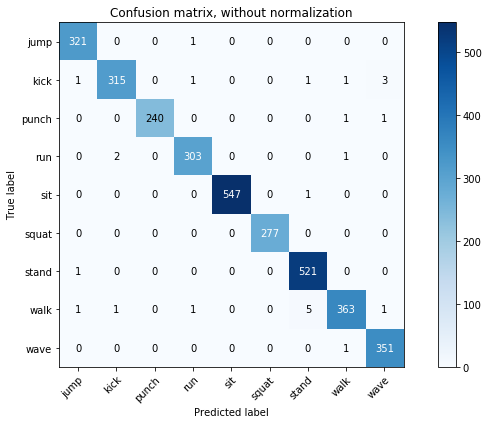

In [15]:
importlib.reload(mydisp)
import time

t0 = time.time()

tr_accu, tr_Y_predict = model.predict_and_evaluate(tr_X, tr_Y)
te_accu, te_Y_predict = model.predict_and_evaluate(te_X, te_Y)

print( "Time cost for predicting one sample:", (time.time()-t0)/len(Y) )

# axis, cf = mydisp.plot_confusion_matrix(tr_Y, tr_Y_predict, classes, normalize=True)
axis, cf = mydisp.plot_confusion_matrix(te_Y, te_Y_predict, classes, normalize=False, size=(10, 6))

In [12]:
from sklearn.metrics import classification_report
print(classification_report(te_Y, te_Y_predict, target_names=classes))

              precision    recall  f1-score   support

        jump       0.99      1.00      0.99       322
        kick       0.99      0.98      0.98       322
       punch       1.00      0.99      1.00       242
         run       0.99      0.99      0.99       306
         sit       1.00      1.00      1.00       548
       squat       1.00      1.00      1.00       277
       stand       0.99      1.00      0.99       522
        walk       0.99      0.98      0.98       372
        wave       0.99      1.00      0.99       352

   micro avg       0.99      0.99      0.99      3263
   macro avg       0.99      0.99      0.99      3263
weighted avg       0.99      0.99      0.99      3263



In [16]:
if model.model_name=="Neural Net":
    
    # Save trained model to file
    import pickle
    path_to_save_model = '../model/trained_classifier.pickle'
    
    with open(path_to_save_model, 'wb') as f:
        pickle.dump(model, f)

    if 0:
        # Load and test again to ensure correctly saved to file
        with open(path_to_save_model, 'rb') as f:
            model2 = pickle.load(f)
        print(tr_X.shape)
        model2.predict_and_evaluate(tr_X, tr_Y)
        model2.predict_and_evaluate(te_X, te_Y)
        print("OK, model is saved to disk. I can test it on webcam")